In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/favorita-grocery-sales-forecasting/test.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/stores.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/items.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/holidays_events.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/transactions.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/train.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/oil.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/sample_submission.csv.7z


In [3]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import pacf,acf
from statsmodels.tsa.arima.model import ARIMA

In [4]:
!pip install py7zr
from subprocess import check_output
import py7zr
for dirname, _, filenames in os.walk('/kaggle/input/favorita-grocery-sales-forecasting'):
    for filename in filenames:
        archive = py7zr.SevenZipFile(os.path.join(dirname, filename), mode='r')
        archive.extractall(path="/kaggle/working")
        archive.close()
print(check_output(["ls", "../working"]).decode("utf8"))
import warnings
warnings.simplefilter('ignore')
#Tip 1.3. Ignore all warnings about later execution ¶
warnings.filterwarnings("ignore", category=FutureWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 22.6 MB/s eta 0:00:00
holidays_events.csv
items.csv
oil.csv
sample_submission.csv
stores.csv
test.csv
train.csv
transactions.csv



In [5]:
df1 = pd.read_csv("../working/train.csv")
df1

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN
...,...,...,...,...,...,...
125497035,125497035,2017-08-15,54,2089339,4.0,False
125497036,125497036,2017-08-15,54,2106464,1.0,True
125497037,125497037,2017-08-15,54,2110456,192.0,False
125497038,125497038,2017-08-15,54,2113914,198.0,True


In [6]:
df2 = pd.read_csv('../working/test.csv')
df2.head(10)

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False
5,125497045,2017-08-16,1,105574,False
6,125497046,2017-08-16,1,105575,False
7,125497047,2017-08-16,1,105576,False
8,125497048,2017-08-16,1,105577,False
9,125497049,2017-08-16,1,105693,False


In [7]:
df3 = pd.read_csv('../working/stores.csv')
df3.head(10)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [8]:
# merging the df1 and the df3 columns on the store_nbr.
df1 = df1.merge(df3, on = ['store_nbr'])
df1.head(10)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,25,103665,7.0,NaN,Salinas,Santa Elena,D,1
1,1,2013-01-01,25,105574,1.0,NaN,Salinas,Santa Elena,D,1
2,2,2013-01-01,25,105575,2.0,NaN,Salinas,Santa Elena,D,1
3,3,2013-01-01,25,108079,1.0,NaN,Salinas,Santa Elena,D,1
4,4,2013-01-01,25,108701,1.0,NaN,Salinas,Santa Elena,D,1
5,5,2013-01-01,25,108786,3.0,NaN,Salinas,Santa Elena,D,1
6,6,2013-01-01,25,108797,1.0,NaN,Salinas,Santa Elena,D,1
7,7,2013-01-01,25,108952,1.0,NaN,Salinas,Santa Elena,D,1
8,8,2013-01-01,25,111397,13.0,NaN,Salinas,Santa Elena,D,1
9,9,2013-01-01,25,114790,3.0,NaN,Salinas,Santa Elena,D,1


In [9]:
print(df1['date'].unique())
print(df1['type'].unique())
print(df1['state'].unique())
print(df1['cluster'].unique())
print(df1['city'].unique())

['2013-01-01' '2013-01-02' '2013-01-03' ... '2017-08-13' '2017-08-14'
 '2017-08-15']
['D' 'B' 'C' 'E' 'A']
['Santa Elena' 'Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi'
 'Chimborazo' 'Imbabura' 'Bolivar' 'Tungurahua' 'Guayas' 'Los Rios'
 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi' 'Pastaza']
[ 1 13  8  9  4  6 15  7  3 12 16 10  2  5 11 14 17]
['Salinas' 'Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba'
 'Ibarra' 'Guaranda' 'Ambato' 'Guayaquil' 'Daule' 'Babahoyo' 'Quevedo'
 'Playas' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas' 'El Carmen' 'Libertad'
 'Manta' 'Puyo']


In [11]:
df1.isna().sum()

id                    0
date                  0
store_nbr             0
item_nbr              0
unit_sales            0
onpromotion    21657651
city                  0
state                 0
type                  0
cluster               0
dtype: int64

In [ ]:
# for time series models we don't need extra variables so we will remove the promotions column and rest we will keep because to do forecasting at
# at different levels by doing the accredation on forecasted time series
df1.drop(columns = ['onpromotion'], inplace = True)
df1.head(10)

In [12]:
# Now we will do the time series forecasting but for some item_nbr only
itn = 108701
stn = 25
df_new1 = df1[(df1['item_nbr']==itn) & (df1['store_nbr']==stn)]
df_new1


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster
4,4,2013-01-01,25,108701,1.0,NaN,Salinas,Santa Elena,D,1
19820,19820,2013-01-02,25,108701,1.0,NaN,Salinas,Santa Elena,D,1
60701,60701,2013-01-03,25,108701,2.0,NaN,Salinas,Santa Elena,D,1
141839,141839,2013-01-05,25,108701,1.0,NaN,Salinas,Santa Elena,D,1
183823,183823,2013-01-06,25,108701,1.0,NaN,Salinas,Santa Elena,D,1
...,...,...,...,...,...,...,...,...,...,...
124919673,124919673,2017-08-10,25,108701,1.0,True,Salinas,Santa Elena,D,1
125019502,125019502,2017-08-11,25,108701,3.0,True,Salinas,Santa Elena,D,1
125125152,125125152,2017-08-12,25,108701,4.0,True,Salinas,Santa Elena,D,1
125336146,125336146,2017-08-14,25,108701,1.0,True,Salinas,Santa Elena,D,1


In [13]:
fig1 = px.line(df_new1,x = 'date',y = 'unit_sales',title = f"Sales Vs Date for item number '{itn}' at store number '{stn}'.")
fig1.update_layout(
    xaxis_title = 'Date',yaxis_title = 'Sales',legend_title = 'Sales vs Date at particular store level'
)
fig1.show()

In [14]:
# Now as we can see that some of the dates are missing so therefore we will consider the unit sales at that day to be zero.
# first lets check the datatype of the date column in df_new1.
print(df_new1['date'].dtype)
# as the datatype of the date is object lets convert it into 'date' datatype.
df_new1['date'] = pd.to_datetime(df_new1['date'])

object


In [15]:
# checking the dtype
print(df_new1['date'].dtype)
# now lets check which all dates are missing.
# creating a date range
date_range = pd.date_range(start = df_new1['date'].min(),end = df_new1['date'].max()) 
df_new11 = pd.DataFrame(date_range,columns = ['date'])
df_new11 = df_new11.merge(df_new1,on = ['date'],how = 'left')
df_new11
#print(date_range)

datetime64[ns]


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster
0,2013-01-01,4.0,25.0,108701.0,1.0,NaN,Salinas,Santa Elena,D,1.0
1,2013-01-02,19820.0,25.0,108701.0,1.0,NaN,Salinas,Santa Elena,D,1.0
2,2013-01-03,60701.0,25.0,108701.0,2.0,NaN,Salinas,Santa Elena,D,1.0
3,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,141839.0,25.0,108701.0,1.0,NaN,Salinas,Santa Elena,D,1.0
...,...,...,...,...,...,...,...,...,...,...
1683,2017-08-11,125019502.0,25.0,108701.0,3.0,True,Salinas,Santa Elena,D,1.0
1684,2017-08-12,125125152.0,25.0,108701.0,4.0,True,Salinas,Santa Elena,D,1.0
1685,2017-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1686,2017-08-14,125336146.0,25.0,108701.0,1.0,True,Salinas,Santa Elena,D,1.0


In [16]:
#id is not important as SKU id is named as item_nbr
df_new11.drop(columns = ['id'],inplace = True)
df_new11.head(2)

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster
0,2013-01-01,25.0,108701.0,1.0,NaN,Salinas,Santa Elena,D,1.0
1,2013-01-02,25.0,108701.0,1.0,NaN,Salinas,Santa Elena,D,1.0


In [17]:
# now filling  the NaN values.
cty = df_new11['city'].mode()[0]
sta  = df_new11['state'].mode()[0]
clu = df_new11['cluster'].mode()[0]
typ = df_new11['type'].mode()[0]
itn1 = df_new11['item_nbr'].mode()[0]
stn1 = df_new11['store_nbr'].mode()[0]
df_new11['city'].fillna(cty,inplace = True)
df_new11['state'].fillna(sta,inplace = True)
df_new11['cluster'].fillna(clu,inplace = True)
df_new11['type'].fillna(typ,inplace = True)
df_new11['item_nbr'].fillna(itn1,inplace = True)
df_new11['store_nbr'].fillna(stn1,inplace = True)

In [18]:
# now filling the sales as 0 for the dates which were missing in the original dataframe.
df_new11.fillna(0,inplace = True)
df_new11

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster
0,2013-01-01,25.0,108701.0,1.0,0,Salinas,Santa Elena,D,1.0
1,2013-01-02,25.0,108701.0,1.0,0,Salinas,Santa Elena,D,1.0
2,2013-01-03,25.0,108701.0,2.0,0,Salinas,Santa Elena,D,1.0
3,2013-01-04,25.0,108701.0,0.0,0,Salinas,Santa Elena,D,1.0
4,2013-01-05,25.0,108701.0,1.0,0,Salinas,Santa Elena,D,1.0
...,...,...,...,...,...,...,...,...,...
1683,2017-08-11,25.0,108701.0,3.0,True,Salinas,Santa Elena,D,1.0
1684,2017-08-12,25.0,108701.0,4.0,True,Salinas,Santa Elena,D,1.0
1685,2017-08-13,25.0,108701.0,0.0,0,Salinas,Santa Elena,D,1.0
1686,2017-08-14,25.0,108701.0,1.0,True,Salinas,Santa Elena,D,1.0


In [19]:
# visualizing with the graph
fig2 = px.line(df_new11,x = 'date',y = 'unit_sales',title = f"Sales Vs Date for item number '{itn}' at store number '{stn}'.")
fig2.update_layout(
    xaxis_title = 'Date',yaxis_title = 'Sales',legend_title = 'Sales vs Date at particular store level'
)
fig2.show()

Now lets come to modelling

In [20]:
# first lets check whether the time series is stationary or not.
X1 = df_new11['unit_sales'].values
result = adfuller(X1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Time Series is Stationary")
else:
    print ("Time Series is Non-Stationary")
# As time series is stationary we can go ahead with our Time Series Models.

ADF Statistic: -7.668214
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Time Series is Stationary


# AR

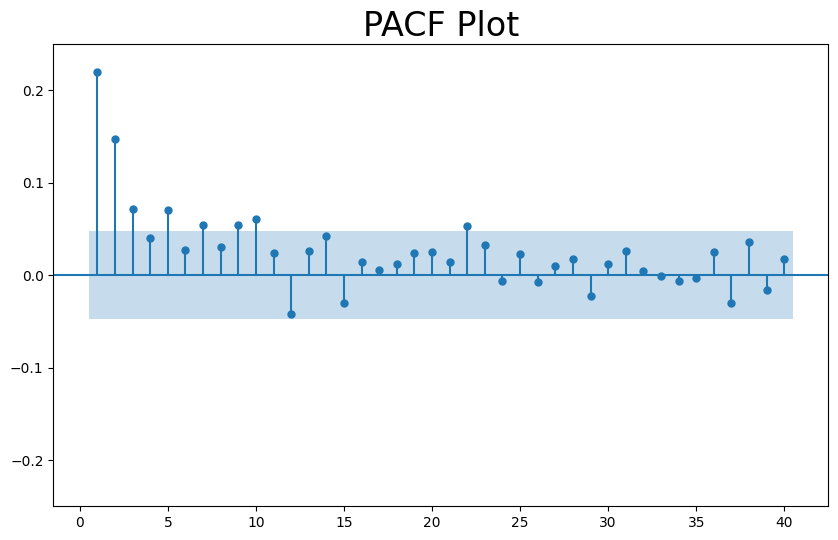

In [21]:
# first we will find the significant lags. For Auto Regressive Model we use the PACF Plot.
lags = 40
acf_fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(X1, lags=lags, zero  = False, ax=ax)
ax.set_title("PACF Plot", size=24)
ax.set_ylim(-0.25, 0.25)
plt.show()

In [22]:
# now to get the lags at which there is the significant values of pacf.
pacf_values, conf_int = pacf(X1, nlags = 30, alpha = 0.05)
# now setting the significanc level (e.g. 0.05 for 95% confidence interval) generally we take this only
significant_lags_pacf1 = np.where(np.abs(pacf_values)> 0.05)[0]
significant_lags_pacf = significant_lags_pacf1[1:]
significant_lags_pacf

array([ 1,  2,  3,  5,  7,  9, 10, 22])

In [23]:
#Now let's create the lagged Dataframe
lagged_data = pd.concat([df_new11['unit_sales'].shift(lag) for lag in range (1,max(significant_lags_pacf)+1)], axis = 1)
lagged_data.columns = [f'Lag_{lag}' for lag in range (1,max(significant_lags_pacf)+1)]
lagged_data_dropped = lagged_data.dropna()
lagged_data_dropped

,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,...,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20,Lag_21,Lag_22
22,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,3.0,1.0,1.0,0.0,2.0,1.0,1.0
23,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,2.0,1.0
24,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,2.0
25,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0
26,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683,1.0,2.0,0.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1684,3.0,1.0,2.0,0.0,2.0,2.0,2.0,3.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1685,4.0,3.0,1.0,2.0,0.0,2.0,2.0,2.0,3.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1686,0.0,4.0,3.0,1.0,2.0,0.0,2.0,2.0,2.0,3.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [24]:
# now to construct the AR model we need to use the significant lags only therefore.
df_new11_final = lagged_data_dropped[[f'Lag_{lag}' for lag in significant_lags_pacf]]
df_new11_final

,Lag_1,Lag_2,Lag_3,Lag_5,Lag_7,Lag_9,Lag_10,Lag_22
22,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
23,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
24,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0
25,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
26,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
1683,1.0,2.0,0.0,2.0,3.0,1.0,1.0,0.0
1684,3.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0
1685,4.0,3.0,1.0,0.0,2.0,3.0,1.0,1.0
1686,0.0,4.0,3.0,2.0,2.0,2.0,3.0,0.0


In [25]:
X_model = df_new11_final
# As from 0 to 22 is removed while creating lags as there were null values.
y_model = df_new11['unit_sales'].iloc[22:,]
y_model

22      1.0
23      0.0
24      1.0
25      1.0
26      0.0
       ... 
1683    3.0
1684    4.0
1685    0.0
1686    1.0
1687    1.0
Name: unit_sales, Length: 1666, dtype: float64

In [26]:
# Creating the training and testing set in ratio of 80:20. This is considered to be general. Also 
# split should not be random
split_index = int(len(X_model)*0.8)
X_model_train = X_model[:split_index]
X_model_test = X_model[split_index:]
y_model_train = y_model[:split_index]
y_model_test = y_model[split_index:]
X_model_test

,Lag_1,Lag_2,Lag_3,Lag_5,Lag_7,Lag_9,Lag_10,Lag_22
1354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1683,1.0,2.0,0.0,2.0,3.0,1.0,1.0,0.0
1684,3.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0
1685,4.0,3.0,1.0,0.0,2.0,3.0,1.0,1.0
1686,0.0,4.0,3.0,2.0,2.0,2.0,3.0,0.0


In [27]:
model = sm.OLS(y_model_train,sm.add_constant(X_model_train)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             unit_sales   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     15.07
Date:                Mon, 19 Feb 2024   Prob (F-statistic):           2.64e-21
Time:                        04:46:10   Log-Likelihood:                -1989.3
No. Observations:                1332   AIC:                             3997.
Df Residuals:                    1323   BIC:                             4043.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3280      0.054      6.116      0.0

In [28]:
y_model_train_pred = model.predict(sm.add_constant(X_model_train))
y_model_test_pred = model.predict(sm.add_constant(X_model_test))
y_model_test_pred

1354    0.327976
1355    0.327976
1356    0.327976
1357    0.327976
1358    0.327976
          ...   
1683    1.052140
1684    1.281601
1685    1.681078
1686    1.430479
1687    0.967797
Length: 334, dtype: float64

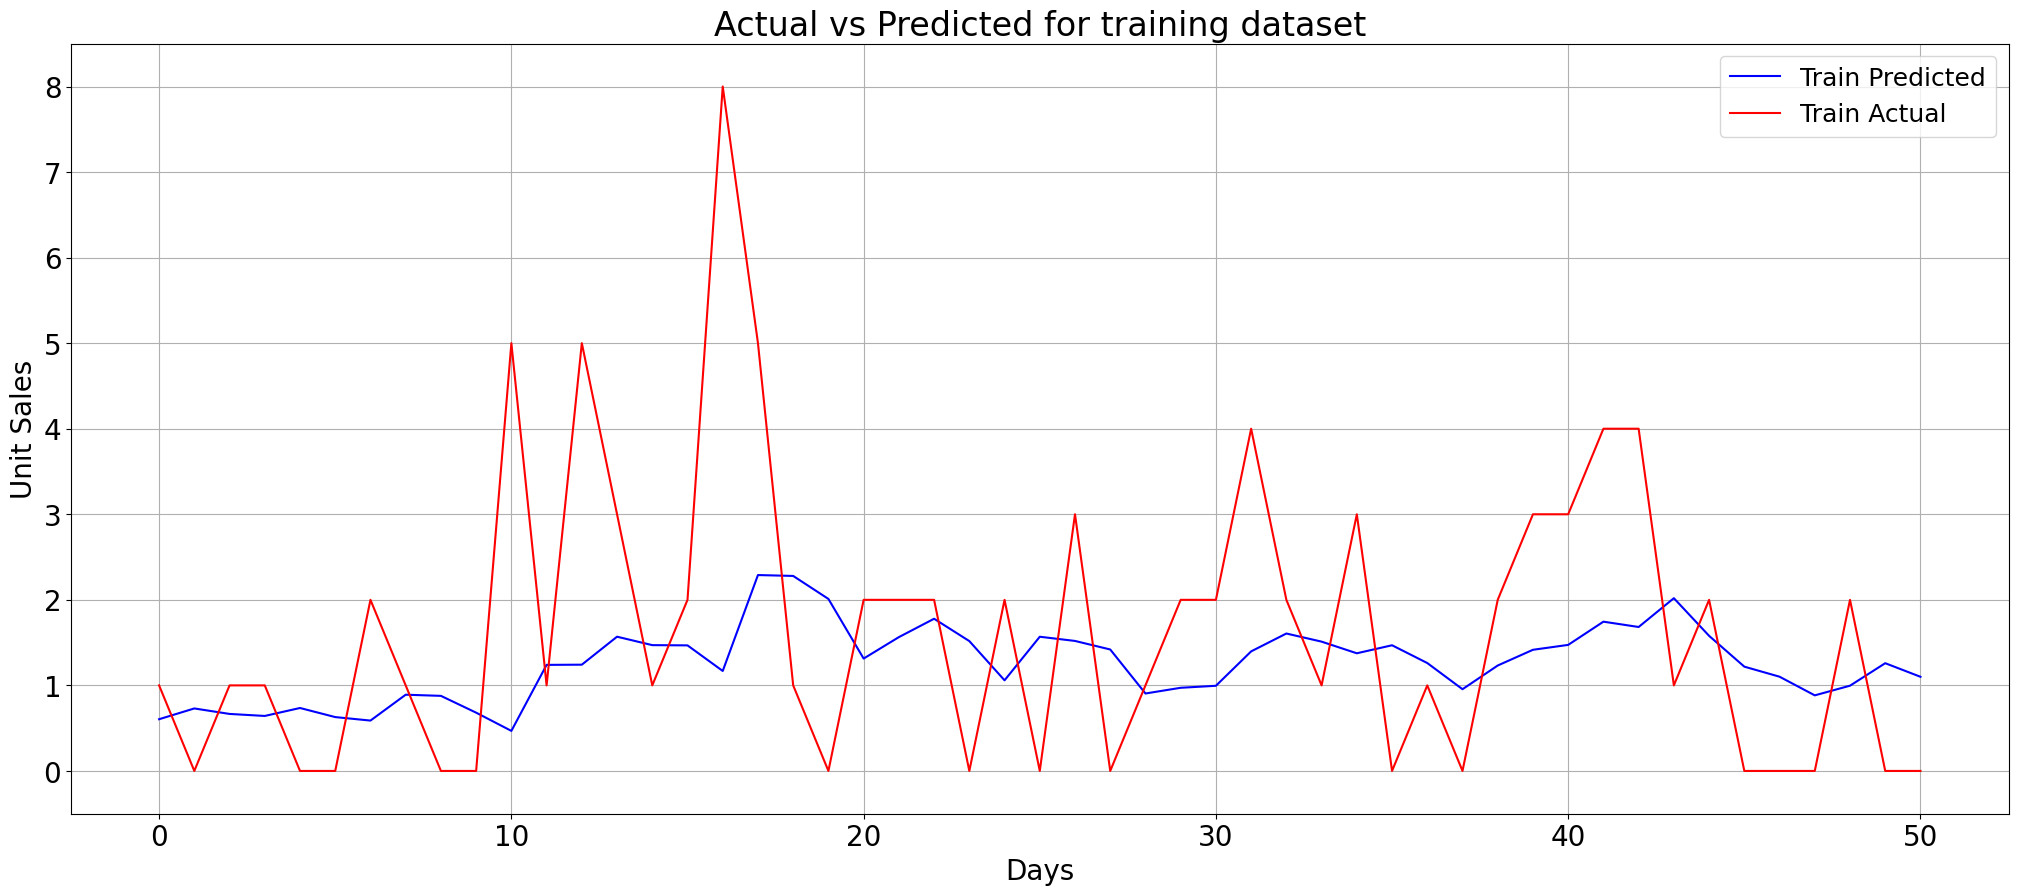

In [95]:
# Ploting the graph of actual vs predicted for training set.
range_train = range(len(X_model_train[:51]))
plt.figure(figsize = (25,10))
plt.plot(range_train,y_model_train_pred[:51],label = 'Train Predicted', color = 'blue')
plt.plot(range_train,y_model_train[:51],label = "Train Actual",color = 'red')
plt.xlabel("Days",size = 20)
plt.ylabel("Unit Sales",size = 20)
plt.title("Actual vs Predicted for training dataset",size = 24)
plt.grid(True)
plt.legend(loc = "upper right",fontsize = "18")
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.ylim(-0.5,8.5)
plt.show()


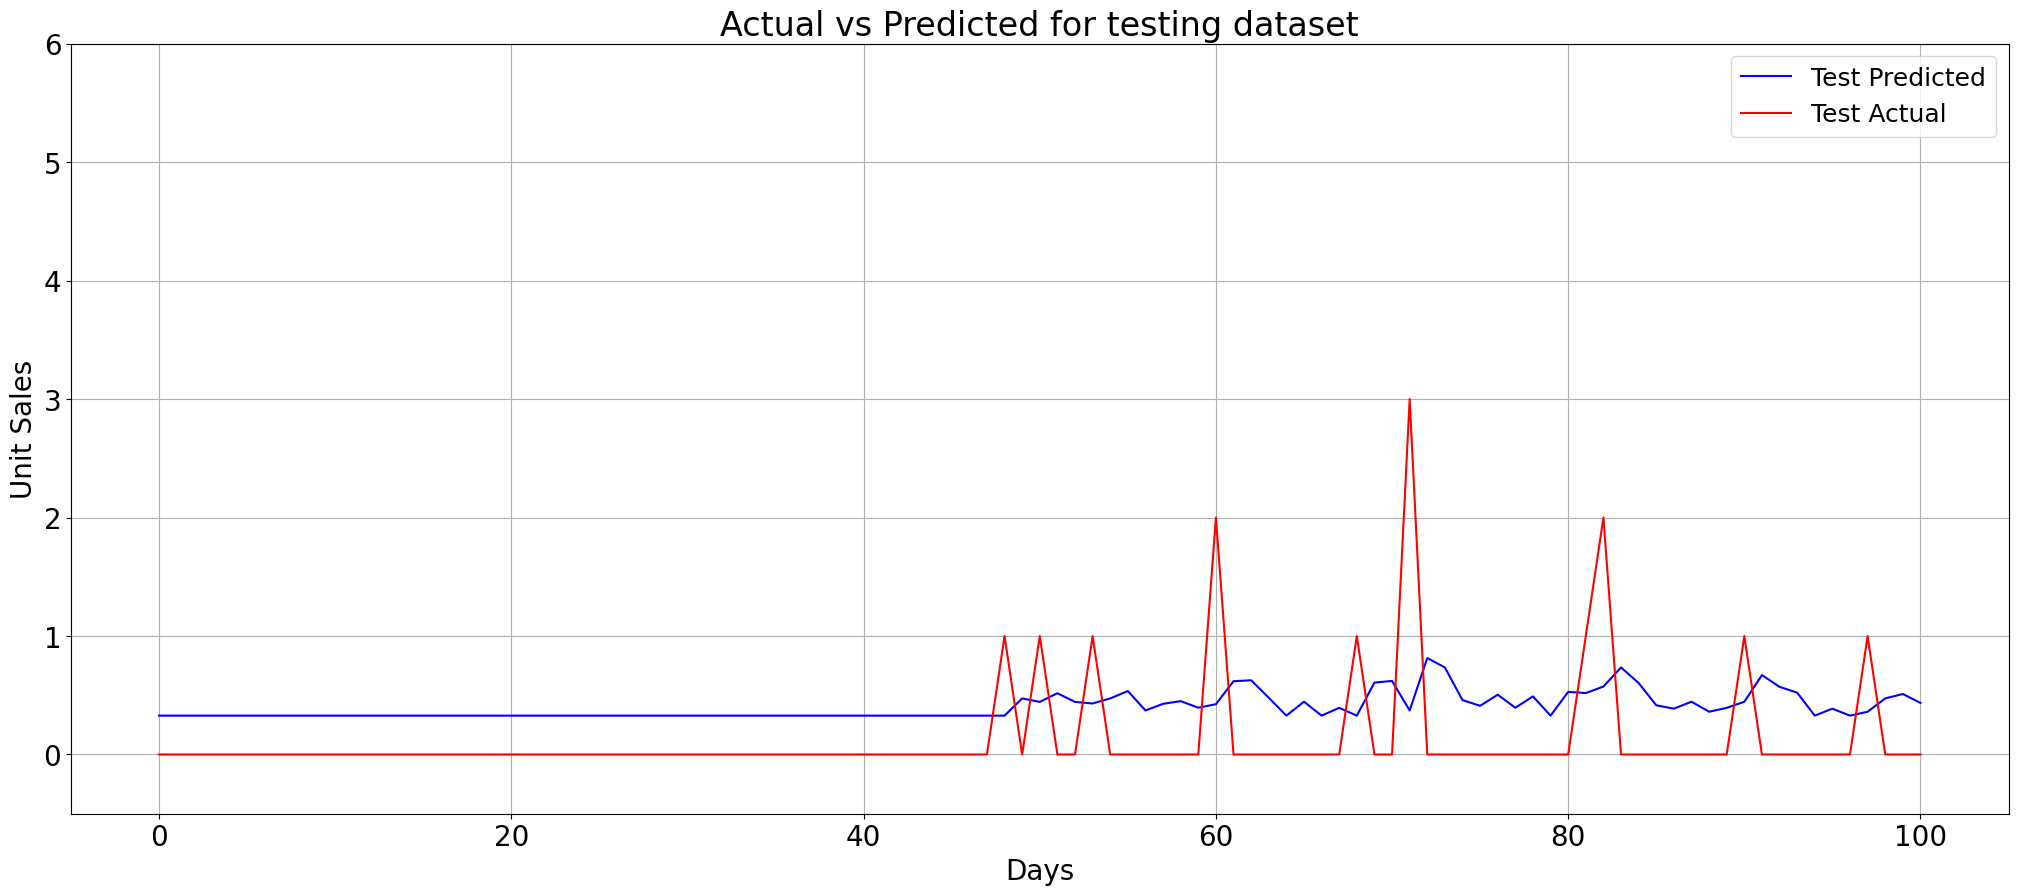

In [92]:
# Ploting the graph of actual vs predicted for training set.
range_test = range(len(X_model_test[:101]))
plt.figure(figsize = (25,10))
plt.plot(range_test,y_model_test_pred[:101],label = 'Test Predicted', color = 'blue')
plt.plot(range_test,y_model_test[:101],label = "Test Actual",color = 'red')
plt.xlabel("Days",size = 20)
plt.ylabel("Unit Sales", size = 20)
plt.title("Actual vs Predicted for testing dataset", size = 24)
plt.grid(True)
plt.legend(loc = "upper right",fontsize = "18")
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.ylim(-0.5,6)
plt.show()

In [32]:
rmse_ar_train = sqrt(mean_squared_error(y_model_train_pred,y_model_train))
rmse_ar_test = sqrt(mean_squared_error(y_model_test_pred,y_model_test))
mse_ar_train = mean_squared_error(y_model_train_pred,y_model_train)
mse_ar_test = mean_squared_error(y_model_test_pred,y_model_test)
mae_ar_train = mean_absolute_error(y_model_train_pred,y_model_train)
mae_ar_test = mean_absolute_error(y_model_test_pred,y_model_test)
print(rmse_ar_train)
print(rmse_ar_test)
print(mse_ar_train)
print(mse_ar_test)
print(mae_ar_train)
print(mae_ar_test)

1.0774146698269171
0.8524381102872207
1.160822370758245
0.7266507318700479
0.7870140798581116
0.6438681119041441


# MA Model

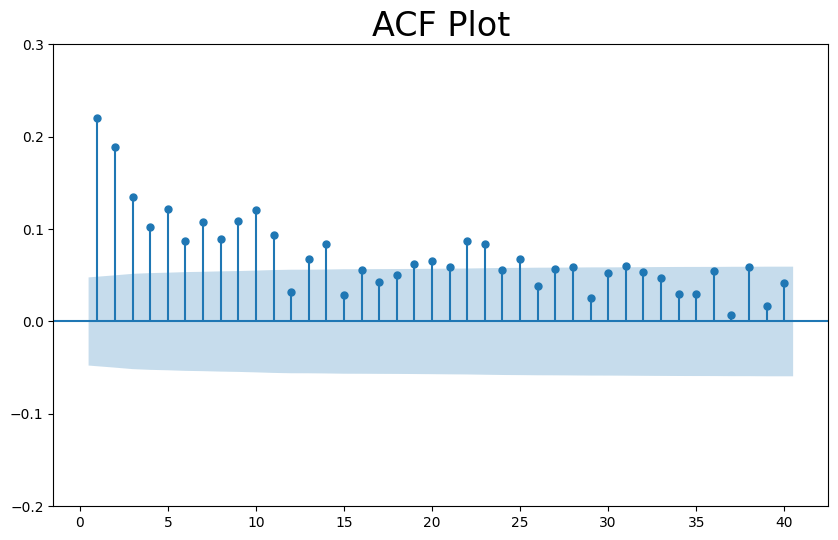

In [33]:
# Plotting the ACF plot for the MA model
lags = 40
acf_fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(X1, lags=lags, zero  = False, ax=ax)
ax.set_title("ACF Plot", size=24)
ax.set_ylim(-0.2, 0.3)
plt.show()

In [34]:
#acf_values,conf_int = acf(X1, nlags = len(X1)-1, alpha = 0.05)
acf_values,conf_int = acf(X1, nlags = 30, alpha = 0.05)
# now setting the significanc level (e.g. 0.05 for 95% confidence interval) generally we take this only
significant_lags_acf1 = np.where(np.abs(acf_values)> 0.05)[0]
significant_lags_acf = significant_lags_acf1[1:]
significant_lags_acf

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 16, 18, 19, 20,
       21, 22, 23, 24, 25, 27, 28, 30])

In [35]:
# so to get the residuals first we need to fit the base line model.
# so we are using the predicted values of the above AR model to calculate the residuals
X_new_ma = X_model.copy()
X_new_ma['Predicted'] = y_model_train_pred
X_new_ma = X_new_ma.dropna()
X_new_ma1 = X_model.iloc[split_index:,]
X_new_ma1['Predicted'] = y_model_test_pred
X_new_ma_final = pd.concat([X_new_ma,X_new_ma1])
X_new_ma_final
# here the row number denotes the day.

,Lag_1,Lag_2,Lag_3,Lag_5,Lag_7,Lag_9,Lag_10,Lag_22,Predicted
22,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.604498
23,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.730487
24,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.666385
25,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.642839
26,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.735824
...,...,...,...,...,...,...,...,...,...
1683,1.0,2.0,0.0,2.0,3.0,1.0,1.0,0.0,1.052140
1684,3.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0,1.281601
1685,4.0,3.0,1.0,0.0,2.0,3.0,1.0,1.0,1.681078
1686,0.0,4.0,3.0,2.0,2.0,2.0,3.0,0.0,1.430479


In [36]:
X_new_ma_final['unit_sales'] = y_model.values
X_new_ma_final

,Lag_1,Lag_2,Lag_3,Lag_5,Lag_7,Lag_9,Lag_10,Lag_22,Predicted,unit_sales
22,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.604498,1.0
23,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.730487,0.0
24,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.666385,1.0
25,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.642839,1.0
26,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.735824,0.0
...,...,...,...,...,...,...,...,...,...,...
1683,1.0,2.0,0.0,2.0,3.0,1.0,1.0,0.0,1.052140,3.0
1684,3.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0,1.281601,4.0
1685,4.0,3.0,1.0,0.0,2.0,3.0,1.0,1.0,1.681078,0.0
1686,0.0,4.0,3.0,2.0,2.0,2.0,3.0,0.0,1.430479,1.0


In [37]:
X_new_ma_final.isna().sum()

Lag_1         0
Lag_2         0
Lag_3         0
Lag_5         0
Lag_7         0
Lag_9         0
Lag_10        0
Lag_22        0
Predicted     0
unit_sales    0
dtype: int64

In [38]:
X_new_ma_final['Residuals'] = (X_new_ma_final['unit_sales'].values  - X_new_ma_final['Predicted'].values)
X_new_ma_final

,Lag_1,Lag_2,Lag_3,Lag_5,Lag_7,Lag_9,Lag_10,Lag_22,Predicted,unit_sales,Residuals
22,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.604498,1.0,0.395502
23,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.730487,0.0,-0.730487
24,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.666385,1.0,0.333615
25,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.642839,1.0,0.357161
26,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.735824,0.0,-0.735824
...,...,...,...,...,...,...,...,...,...,...,...
1683,1.0,2.0,0.0,2.0,3.0,1.0,1.0,0.0,1.052140,3.0,1.947860
1684,3.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0,1.281601,4.0,2.718399
1685,4.0,3.0,1.0,0.0,2.0,3.0,1.0,1.0,1.681078,0.0,-1.681078
1686,0.0,4.0,3.0,2.0,2.0,2.0,3.0,0.0,1.430479,1.0,-0.430479


In [39]:
X_new_ma_final = X_new_ma_final[['Residuals']]
X_new_ma_final

,Residuals
22,0.395502
23,-0.730487
24,0.333615
25,0.357161
26,-0.735824
...,...
1683,1.947860
1684,2.718399
1685,-1.681078
1686,-0.430479


In [40]:
X_new_ma_final['Day'] = 'd_' + X_new_ma_final.index.astype(str)
X_new_ma_final

,Residuals,Day
22,0.395502,d_22
23,-0.730487,d_23
24,0.333615,d_24
25,0.357161,d_25
26,-0.735824,d_26
...,...,...
1683,1.947860,d_1683
1684,2.718399,d_1684
1685,-1.681078,d_1685
1686,-0.430479,d_1686


In [41]:
# lest have the adfuller test for residuals.
X2 = X_new_ma_final['Residuals'].values
result = adfuller(X2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Time Series is Stationary")
else:
    print ("Time Series is Non-Stationary")

# again it is stationary only.

ADF Statistic: -40.340021
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Time Series is Stationary


In [49]:
# Now we will prepare the AR model for this regressor.
acf_values_ma, conf_int = acf(X2, nlags = 30, alpha = 0.05)
# now setting the significanc level (e.g. 0.05 for 95% confidence interval) generally we take this only
significant_lags_acf_ma1 = np.where(np.abs(acf_values_ma)> 0.05)[0]
significant_lags_acf_ma = significant_lags_acf_ma1[0:]
significant_lags_acf_ma

array([ 0, 12])

In [50]:
#Now let's create the lagged Dataframe
lagged_data_ma = pd.concat([X_new_ma_final['Residuals'].shift(lag) for lag in range (0,max(significant_lags_acf_ma)+1)], axis = 1)
# lagged_data_ma = pd.concat([X_new_ma_final['Residuals'].shift(lag) for lag in range (0,26)], axis = 1)
lagged_data_ma.columns = [f'Lag1_{lag}' for lag in range (0,max(significant_lags_acf_ma)+1)]
# lagged_data_ma.columns = [f'Lag1_{lag}' for lag in range (0,26)]
lagged_data_ma['Day'] = X_new_ma_final['Day'].values
lagged_data_dropped_ma = lagged_data_ma.dropna()
lagged_data_dropped_ma

,Lag1_0,Lag1_1,Lag1_2,Lag1_3,Lag1_4,Lag1_5,Lag1_6,Lag1_7,Lag1_8,Lag1_9,Lag1_10,Lag1_11,Lag1_12,Day
34,3.757958,-0.239730,4.531858,-0.681183,-0.877627,0.108925,1.411229,-0.629508,-0.735824,0.357161,0.333615,-0.730487,0.395502,d_34
35,1.430864,3.757958,-0.239730,4.531858,-0.681183,-0.877627,0.108925,1.411229,-0.629508,-0.735824,0.357161,0.333615,-0.730487,d_35
36,-0.470490,1.430864,3.757958,-0.239730,4.531858,-0.681183,-0.877627,0.108925,1.411229,-0.629508,-0.735824,0.357161,0.333615,d_36
37,0.532270,-0.470490,1.430864,3.757958,-0.239730,4.531858,-0.681183,-0.877627,0.108925,1.411229,-0.629508,-0.735824,0.357161,d_37
38,6.831351,0.532270,-0.470490,1.430864,3.757958,-0.239730,4.531858,-0.681183,-0.877627,0.108925,1.411229,-0.629508,-0.735824,d_38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683,1.947860,-0.037397,1.076379,-1.093388,0.796061,0.800579,0.917441,2.233853,0.275139,0.351824,0.360510,0.445583,-0.633022,d_1683
1684,2.718399,1.947860,-0.037397,1.076379,-1.093388,0.796061,0.800579,0.917441,2.233853,0.275139,0.351824,0.360510,0.445583,d_1684
1685,-1.681078,2.718399,1.947860,-0.037397,1.076379,-1.093388,0.796061,0.800579,0.917441,2.233853,0.275139,0.351824,0.360510,d_1685
1686,-0.430479,-1.681078,2.718399,1.947860,-0.037397,1.076379,-1.093388,0.796061,0.800579,0.917441,2.233853,0.275139,0.351824,d_1686


In [51]:
X_model_ma = lagged_data_dropped_ma[[f'Lag1_{lag}' for lag in significant_lags_acf_ma]]
# df_model_final_ma = lagged_data_dropped_ma[['Lag1_0','Lag1_25']]
# X_model_ma['Day'] = lagged_data_dropped_ma['Day'].values
X_model_ma

,Lag1_0,Lag1_12
34,3.757958,0.395502
35,1.430864,-0.730487
36,-0.470490,0.333615
37,0.532270,0.357161
38,6.831351,-0.735824
...,...,...
1683,1.947860,-0.633022
1684,2.718399,0.445583
1685,-1.681078,0.360510
1686,-0.430479,0.351824


In [52]:
y_model_ma = y_model.loc[34:]
y_model_ma

34      5.0
35      3.0
36      1.0
37      2.0
38      8.0
       ... 
1683    3.0
1684    4.0
1685    0.0
1686    1.0
1687    1.0
Name: unit_sales, Length: 1654, dtype: float64

In [53]:
split_index1 = int(len(X_model_ma)*0.8)
X_model_train1 = X_model_ma[:split_index1]
X_model_test1 = X_model_ma[split_index1:]
y_model_train1 = y_model_ma[:split_index1]
y_model_test1 = y_model_ma[split_index1:]
X_model_test1

,Lag1_0,Lag1_12
1357,-0.327976,-0.428139
1358,-0.327976,-0.378058
1359,-0.327976,-0.378058
1360,-0.327976,-0.378058
1361,-0.327976,-0.428139
...,...,...
1683,1.947860,-0.633022
1684,2.718399,0.445583
1685,-1.681078,0.360510
1686,-0.430479,0.351824


In [54]:
model1 = sm.OLS(y_model_train1,sm.add_constant(X_model_train1)).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:             unit_sales   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     7304.
Date:                Mon, 19 Feb 2024   Prob (F-statistic):               0.00
Time:                        04:54:38   Log-Likelihood:                -382.42
No. Observations:                1323   AIC:                             770.8
Df Residuals:                    1320   BIC:                             786.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7786      0.009     87.560      0.0

In [55]:
y_model_train_pred1 = model1.predict(sm.add_constant(X_model_train1))
y_model_test_pred1 = model1.predict(sm.add_constant(X_model_test1))
y_model_test_pred1

1357    0.430695
1358    0.432885
1359    0.432885
1360    0.432885
1361    0.430695
          ...   
1683    2.705992
1684    3.526546
1685   -0.892925
1686    0.361920
1687    0.822961
Length: 331, dtype: float64

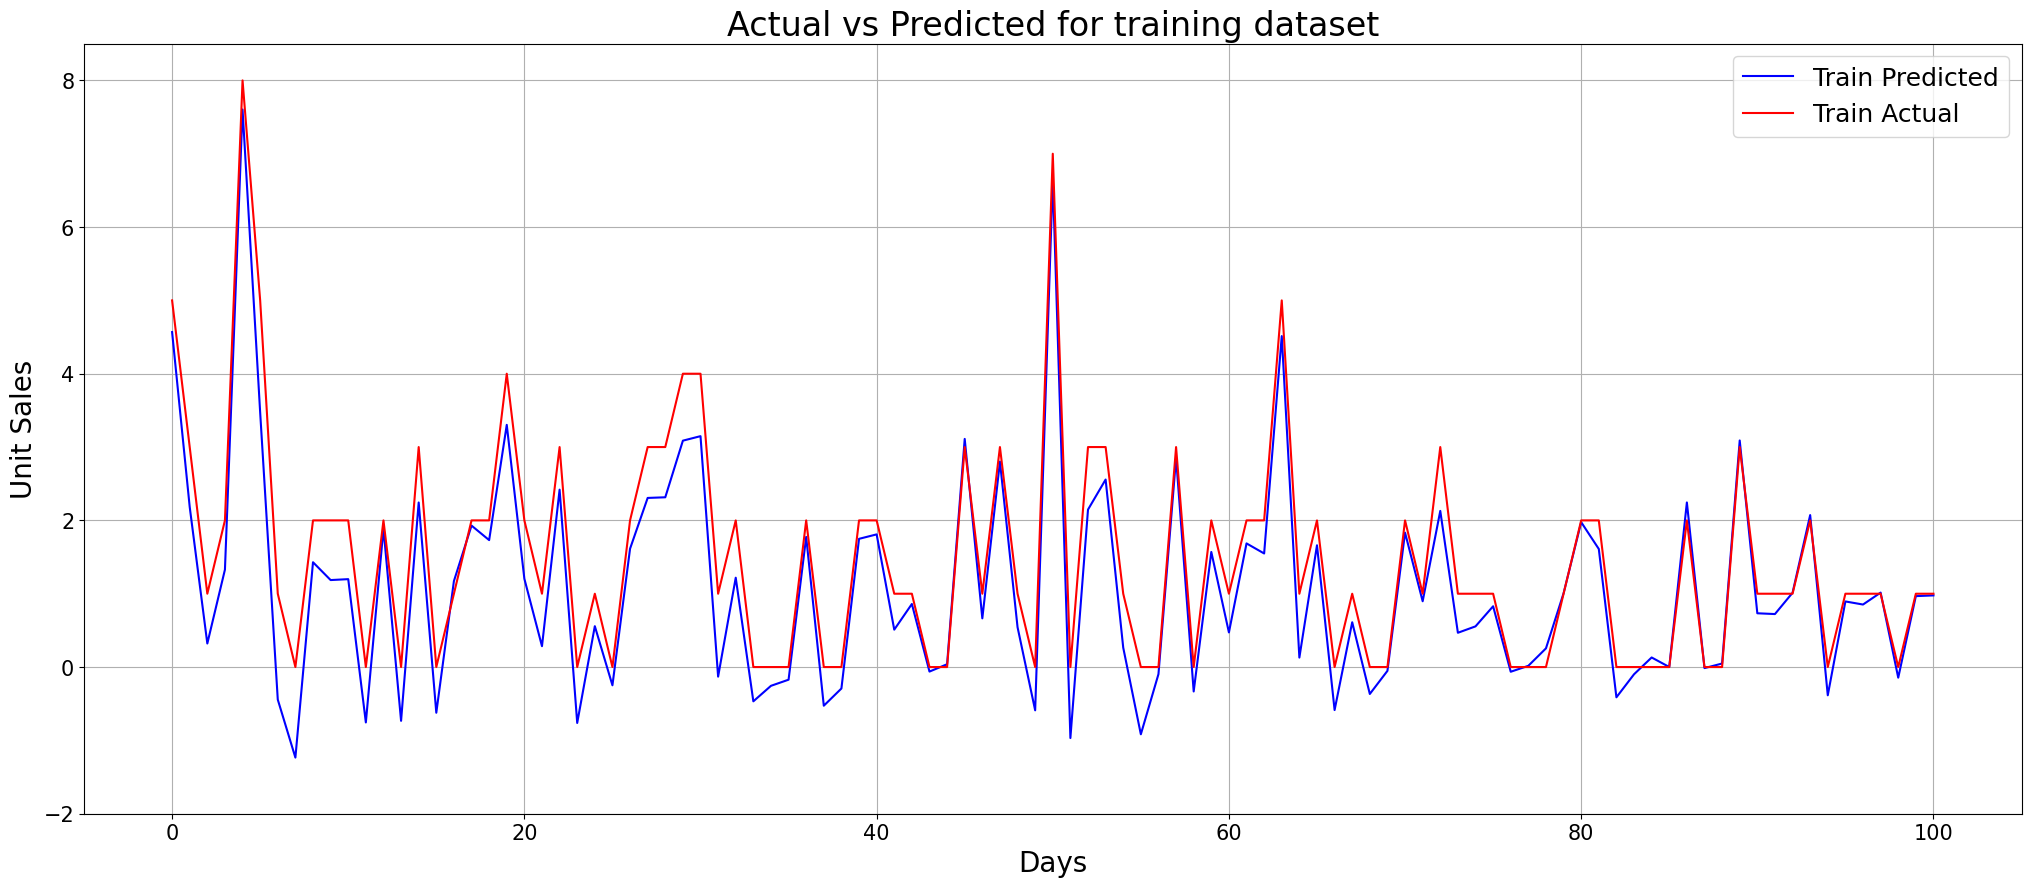

In [96]:
# Ploting the graph of actual vs predicted for training set.
range_train1 = range(len(X_model_train1[:101]))
plt.figure(figsize = (25,10))
plt.plot(range_train1,y_model_train_pred1[:101],label = 'Train Predicted', color = 'blue')
plt.plot(range_train1,y_model_train1[:101],label = "Train Actual",color = 'red')
plt.xlabel("Days", size = 20)
plt.ylabel("Unit Sales", size = 20)
plt.title("Actual vs Predicted for training dataset", size = 24)
plt.grid(True)
plt.legend(loc = "upper right",fontsize = "18")
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.ylim(-2,8.5)
plt.show()


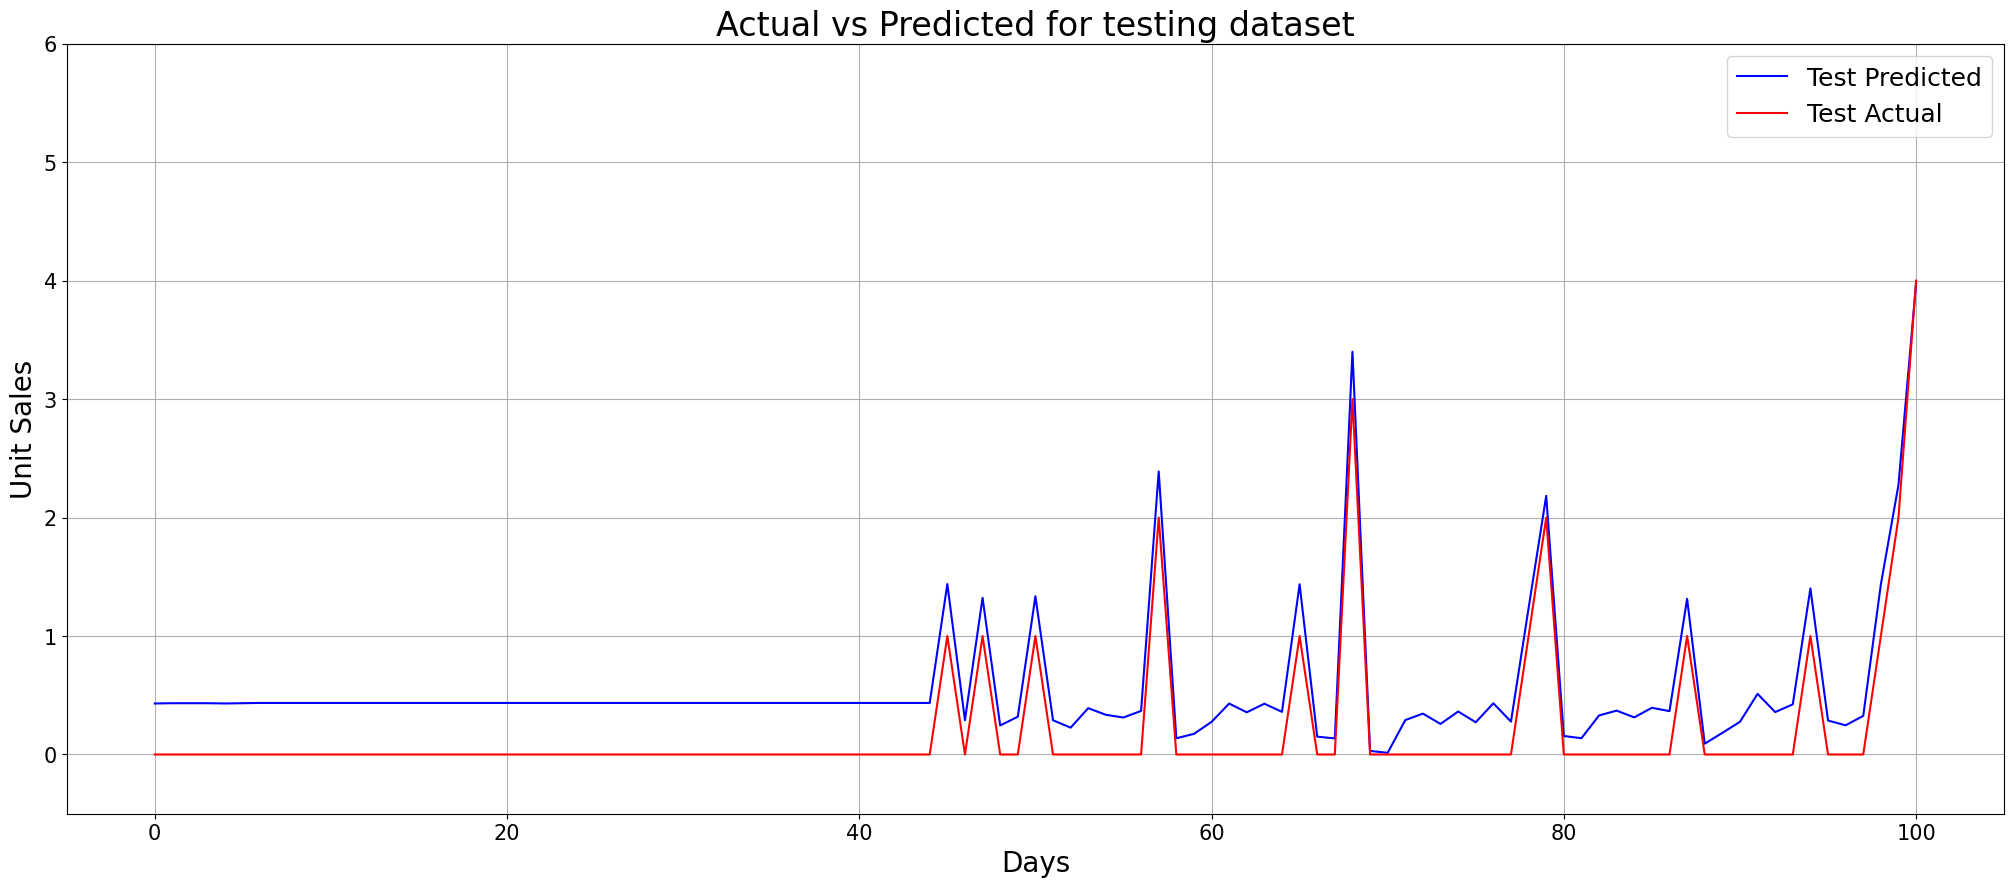

In [97]:
# Ploting the graph of actual vs predicted for training set.
range_test1 = range(len(X_model_test1[:101]))
plt.figure(figsize = (25,10))
plt.plot(range_test1,y_model_test_pred1[:101],label = 'Test Predicted', color = 'blue')
plt.plot(range_test1,y_model_test1[:101],label = "Test Actual",color = 'red')
plt.xlabel("Days", size = 20)
plt.ylabel("Unit Sales",size = 20)
plt.title("Actual vs Predicted for testing dataset", size = 24)
plt.grid(True)
plt.legend(loc = "upper right",fontsize = "18")
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.ylim(-0.5,6)
plt.show()

In [58]:
rmse_ma_train = sqrt(mean_squared_error(y_model_train_pred1,y_model_train1))
rmse_ma_test = sqrt(mean_squared_error(y_model_test_pred1,y_model_test1))
mse_ma_train = mean_squared_error(y_model_train_pred1,y_model_train1)
mse_ma_test = mean_squared_error(y_model_test_pred1,y_model_test1)
mae_ma_train = mean_absolute_error(y_model_train_pred1,y_model_train1)
mae_ma_test = mean_absolute_error(y_model_test_pred1,y_model_test1)
print(rmse_ma_train)
print(rmse_ma_test)
print(mse_ma_train)
print(mse_ma_test)
print(mae_ma_train)
print(mae_ma_test)

0.3230709614645719
0.3085787348319428
0.10437484614164293
0.09522083559048249
0.24976666866899302
0.2626750925400725


# ARMA Model

In [78]:
X_model1 = X_model.loc[34:,]
X_model_arma = pd.concat([X_model1,X_model_ma],axis = 1)
# we have reduced the order of AR in ARMA as the final result was resulting in overfitting
X_model_arma = X_model_arma[['Lag_1','Lag_2','Lag_3','Lag_5','Lag1_0']]
X_model_arma

,Lag_1,Lag_2,Lag_3,Lag_5,Lag1_0
34,1.0,5.0,0.0,1.0,3.757958
35,5.0,1.0,5.0,0.0,1.430864
36,3.0,5.0,1.0,0.0,-0.470490
37,1.0,3.0,5.0,5.0,0.532270
38,2.0,1.0,3.0,1.0,6.831351
...,...,...,...,...,...
1683,1.0,2.0,0.0,2.0,1.947860
1684,3.0,1.0,2.0,2.0,2.718399
1685,4.0,3.0,1.0,0.0,-1.681078
1686,0.0,4.0,3.0,2.0,-0.430479


In [79]:
y_model_arma = y_model_ma.copy()
y_model_arma

34      5.0
35      3.0
36      1.0
37      2.0
38      8.0
       ... 
1683    3.0
1684    4.0
1685    0.0
1686    1.0
1687    1.0
Name: unit_sales, Length: 1654, dtype: float64

In [80]:
split_index2 = int(len(X_model_arma)*0.8)
X_model_train2 = X_model_arma[:split_index2]
X_model_test2 = X_model_arma[split_index2:]
y_model_train2 = y_model_arma[:split_index2]
y_model_test2 = y_model_arma[split_index2:]
y_model_test2

1357    0.0
1358    0.0
1359    0.0
1360    0.0
1361    0.0
       ... 
1683    3.0
1684    4.0
1685    0.0
1686    1.0
1687    1.0
Name: unit_sales, Length: 331, dtype: float64

In [81]:
model2 = sm.OLS(y_model_train2,sm.add_constant(X_model_train2)).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:             unit_sales   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 1.745e+04
Date:                Mon, 19 Feb 2024   Prob (F-statistic):               0.00
Time:                        05:11:05   Log-Likelihood:                 753.87
No. Observations:                1323   AIC:                            -1496.
Df Residuals:                    1317   BIC:                            -1465.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4566      0.006     80.053      0.0

In [82]:
y_model_train_pred2 = model2.predict(sm.add_constant(X_model_train2))
y_model_test_pred2 = model2.predict(sm.add_constant(X_model_test2))
y_model_test_pred2

1357    0.128623
1358    0.128623
1359    0.128623
1360    0.128623
1361    0.128623
          ...   
1683    2.968446
1684    4.032321
1685   -0.163271
1686    0.846781
1687    0.935335
Length: 331, dtype: float64

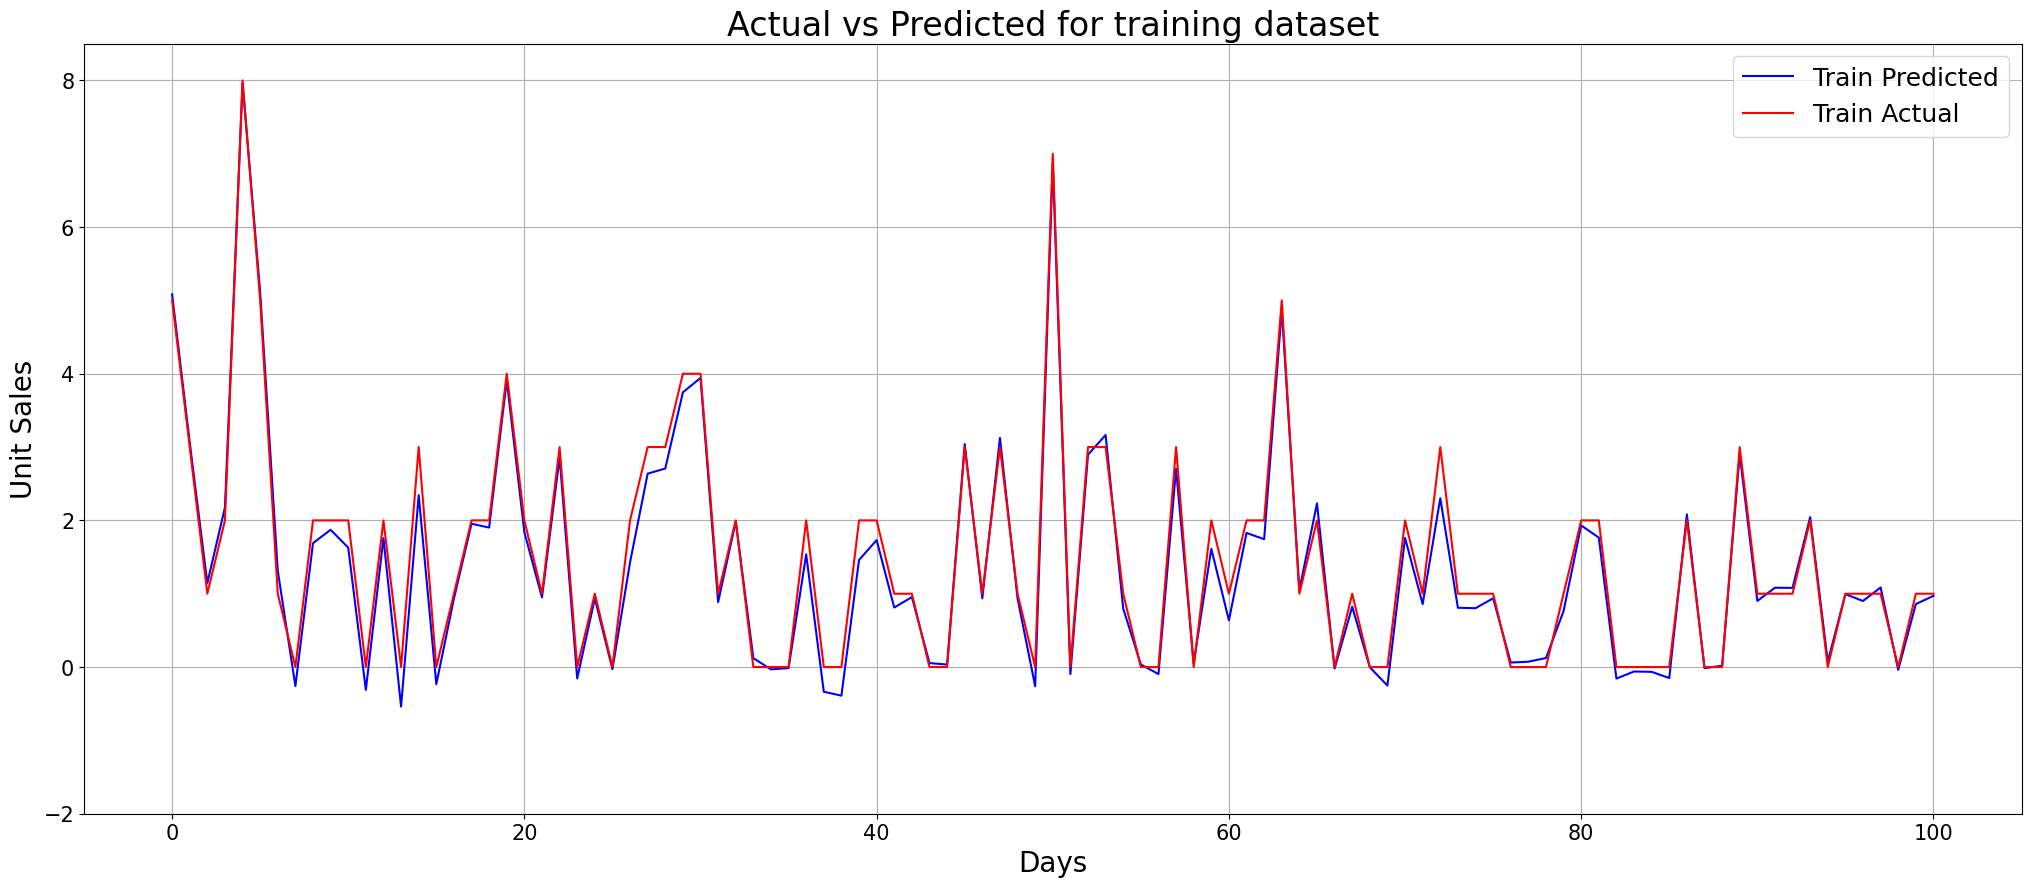

In [98]:
# Ploting the graph of actual vs predicted for training set.
range_train2 = range(len(X_model_train2[:101]))
plt.figure(figsize = (25,10))
plt.plot(range_train2,y_model_train_pred2[:101],label = 'Train Predicted', color = 'blue')
plt.plot(range_train2,y_model_train2[:101],label = "Train Actual",color = 'red')
plt.xlabel("Days",size = 20)
plt.ylabel("Unit Sales",size = 20)
plt.title("Actual vs Predicted for training dataset",size = 24)
plt.grid(True)
plt.legend(loc = "upper right",fontsize = "18")
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.ylim(-2,8.5)
plt.show()


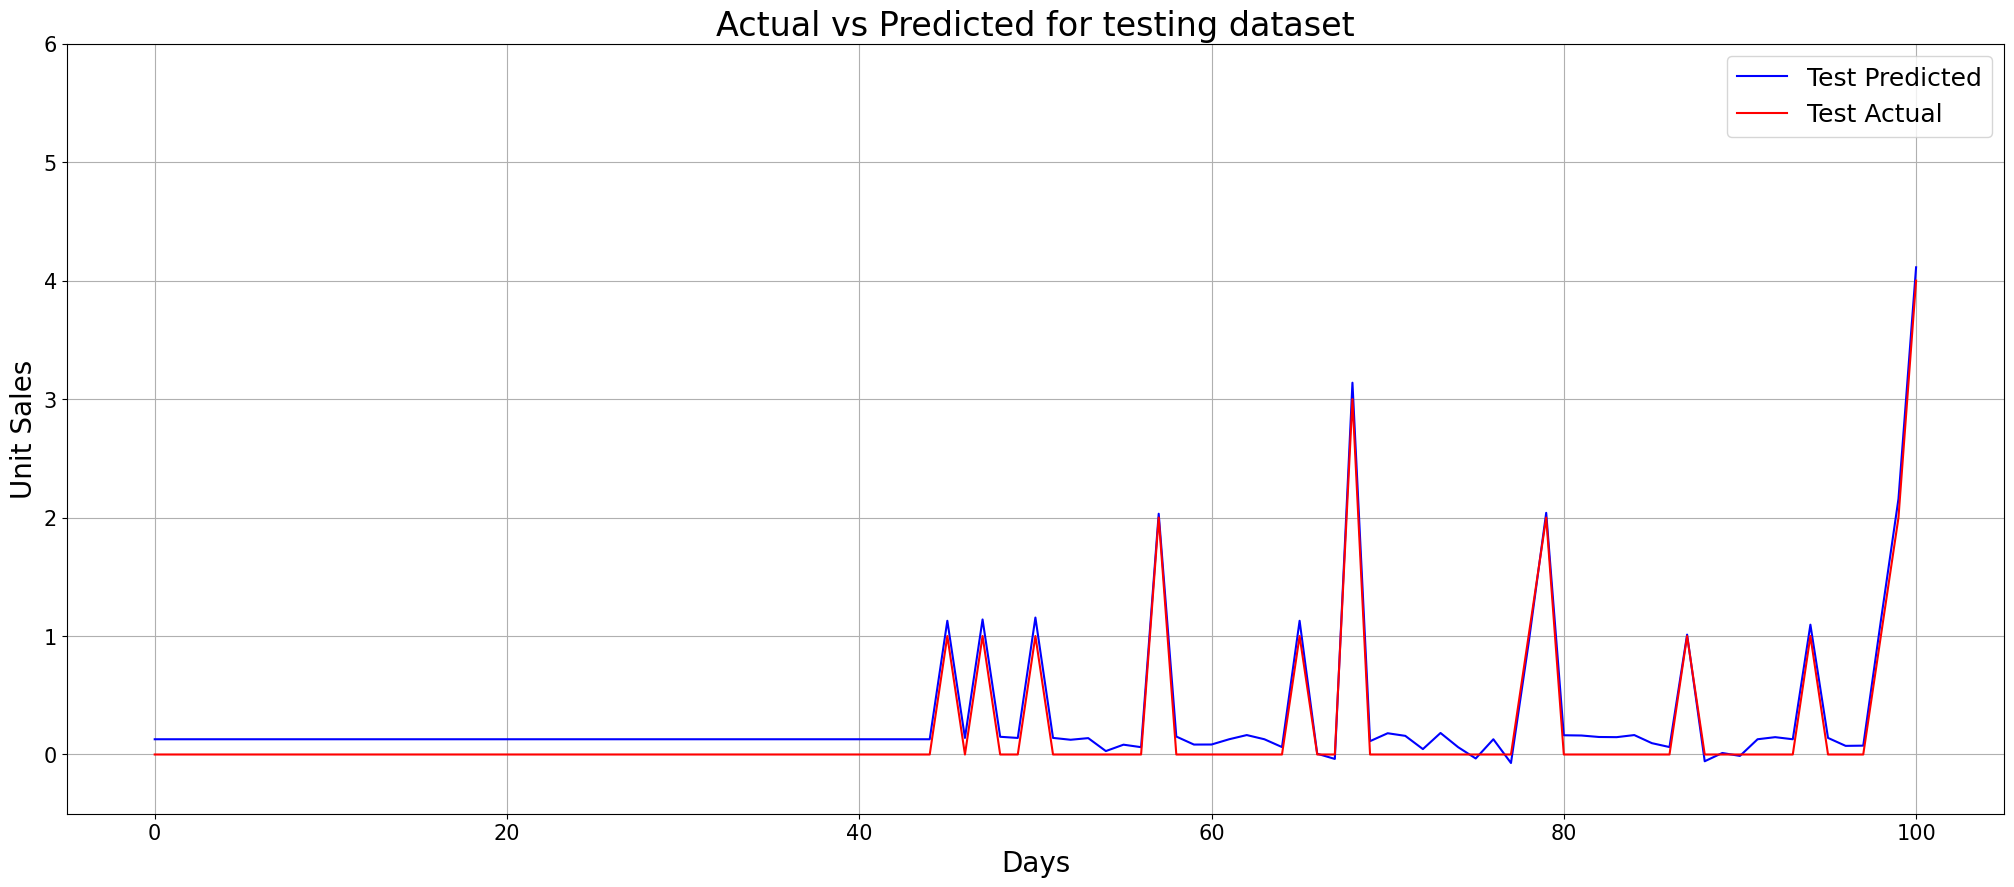

In [99]:
# Ploting the graph of actual vs predicted for training set.
range_test2 = range(len(X_model_test2[:101]))
plt.figure(figsize = (25,10))
plt.plot(range_test2,y_model_test_pred2[:101],label = 'Test Predicted', color = 'blue')
plt.plot(range_test2,y_model_test2[:101],label = "Test Actual",color = 'red')
plt.xlabel("Days",size= 20)
plt.ylabel("Unit Sales",size=20)
plt.title("Actual vs Predicted for testing dataset",size = 24)
plt.grid(True)
plt.legend(loc = "upper right",fontsize = "18")
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.ylim(-0.5,6)
plt.show()

In [100]:
rmse_arma_train = sqrt(mean_squared_error(y_model_train_pred2,y_model_train2))
rmse_arma_test = sqrt(mean_squared_error(y_model_test_pred2,y_model_test2))
mse_arma_train = mean_squared_error(y_model_train_pred2,y_model_train2)
mse_arma_test = mean_squared_error(y_model_test_pred2,y_model_test2)
mae_arma_train = mean_absolute_error(y_model_train_pred2,y_model_train2)
mae_arma_test = mean_absolute_error(y_model_test_pred2,y_model_test2)
print(rmse_arma_train)
print(rmse_arma_test)
print(mse_arma_train)
print(mse_arma_test)
print(mae_arma_train)
print(mae_arma_test)

0.1368653810548973
0.11984109042252135
0.01873213253130224
0.014361886953658937
0.10222950724472146
0.09927783040512676
